In [1]:
import uproot
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
import time
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split

#### To do: 
* Add intro describing MET and the ML problem to be solved
* Explain what the variables are

In [2]:
inFile = '/Users/hodkinson/Teaching/CMPP/ttbar_METNTuple.root'

# open file with uproot
f = uproot.open(inFile)['None/Nominal']
#print(f.keys()) # print tree names

In [3]:
features = [#'NPV', 
            'averageInteractionsPerCrossing', 
            'nel', #'el_pt', 'el_phi', 'el_eta', 'el_charge',
            'nmuon', #'muon_pt', 'muon_phi', 'muon_eta', 'muon_charge',
            #'nph', #'ph_m', 'ph_pt', 'ph_phi', 'ph_eta', 
            #'ntau', 'tau_m', 'tau_pt', 'tau_phi', 'tau_eta', 'tau_ntrk', 'tau_charge', 
            'njet', #'jet_E', 'jet_pt', 'jet_phi', 'jet_eta', #'jet_rapidity', 'jet_detectorEta', 
            #'jet_Jvt', 'jet_fJvt', 'jet_NNJvt', 'jet_NNJvtPass', 'jet_JvtPass_FixedEffPt', 'jet_passOR',
            #'nbjet', 'NPV_fourTrks', 'PV_nTrks', 'nfwdjet', 'sumPt_fwdjets', 'nTrks', 'ntightjet'

            'Tight_TST_pxmetEle', 'Tight_TST_pymetEle', 'Tight_TST_sumpTmetEle', #'Tight_TST_pTmetEle', 
            'Tight_TST_pxmetMuon', 'Tight_TST_pymetMuon', 'Tight_TST_sumpTmetMuon', #'Tight_TST_pTmetMuon', 
            #'Tight_TST_pxmetTauJet', 'Tight_TST_pymetTauJet', 'Tight_TST_sumpTmetTauJet', 'Tight_TST_pTmetTauJet', 
            #'Tight_TST_pxmetPhoton', 'Tight_TST_pymetPhoton', 'Tight_TST_sumpTmetPhoton', 'Tight_TST_pTmetPhoton', 
            'Tight_TST_EleVarL', 'Tight_TST_EleVarT', 
            'Tight_TST_MuonVarL', 'Tight_TST_MuonVarT', 
            #'Tight_TST_PhotonVarL', 'Tight_TST_PhotonVarT', 
            #'Tight_TST_TauVarL', 'Tight_TST_TauVarT',
           ]
WP_features = [
            'Tight_TST_pxSoft', 'Tight_TST_pySoft', 'Tight_TST_sumpTSoft', #'Tight_TST_pTSoft', 
            'Tight_TST_pxMiss', 'Tight_TST_pyMiss', 'Tight_TST_sumpTMiss', #'Tight_TST_pTMiss', 
            'Tight_TST_pxmetJet', 'Tight_TST_pymetJet', 'Tight_TST_sumpTmetJet', #'Tight_TST_pTmetJet', 
            #'Tight_TST_metOverSqrtSumEt', 'Tight_TST_metOverSqrtHt', 'Tight_TST_metSignificance', 
            #'Tight_TST_metSigDirectional', 'Tight_TST_Rho', 'Tight_TST_VarL', 'Tight_TST_VarT', 
            'Tight_TST_JetVarL', 'Tight_TST_JetVarT', 'Tight_TST_SoftVarL', 'Tight_TST_SoftVarT', 
           ]

for WP in ['Tight','Tighter','Loose','Tenacious']:
    for feat in WP_features:
        features.append(feat.replace('Tight',WP))

targets = ['TruthpxMiss', 'TruthpyMiss']

In [4]:
X = f.arrays(features,library="pd")
y = f.arrays(targets,library="pd")

#### Plot some features

In [5]:
def plot_feature(feature, **kwargs):
    fig, ax = plt.subplots()
    if 'Truth' in feature:
        ax.hist(y[feature], **kwargs)
    else:
        ax.hist(X[feature], **kwargs)
    ax.set_yscale('log')
    ax.set_xlabel(feature)
    plt.show()

def plot_difference(feature1, feature2, **kwargs):
    if 'Truth' in feature1: v1 = y[feature1]
    else: v1 = X[feature1]
    if 'Truth' in feature2: v2 = y[feature2]
    else: v2 = X[feature2]
    fig, ax = plt.subplots()
    ax.hist(v1-v2, **kwargs)
    ax.set_yscale('log')
    ax.set_xlabel(f'$\\Delta(${feature1}, {feature2}$)$')
    plt.show()

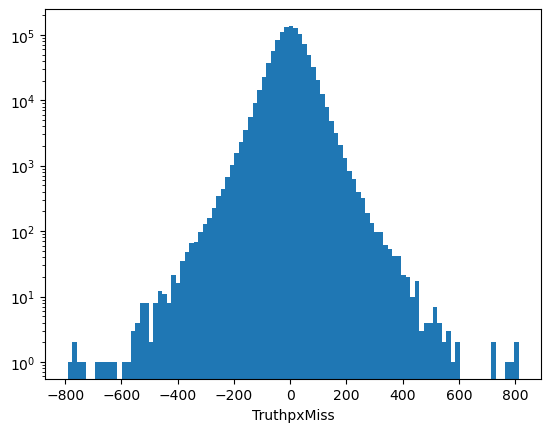

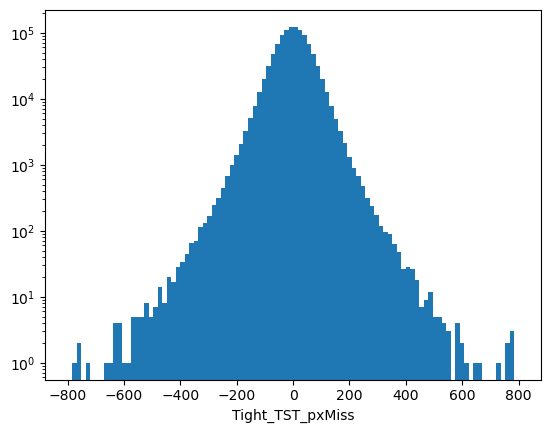

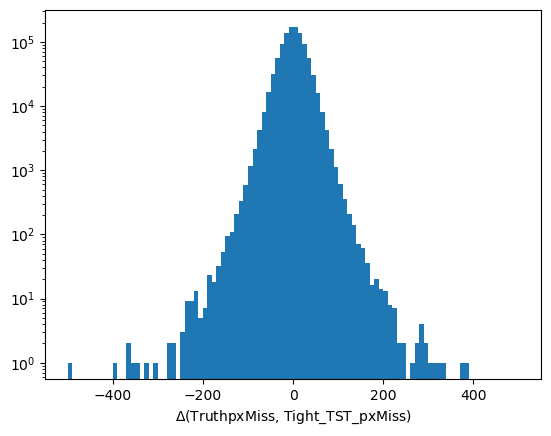

In [6]:
plot_feature('TruthpxMiss',bins=100)
plot_feature('Tight_TST_pxMiss',bins=100,range=(-800,800))
plot_difference('TruthpxMiss','Tight_TST_pxMiss',bins=100, range=(-500,500))

#### Split into train and test sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=7) 

#### Set-up Keras model

In [8]:
# set-up keras model
BATCH_SIZE = 256
nEPOCHS = 3
LEARNING_RATE=0.1

# Input layer
Input_1 = Input(shape=(len(features),),name="Input")

# Normalization layer (to scale input features)
Norm_layer = tf.keras.layers.Normalization()
# learn means and variances for feature normalization:
Norm_layer.adapt(X_train.values)
x = Norm_layer(Input_1)

# hidden layers
x = Dense(100,activation='relu',name='Layer1')(x)
x = Dense(100,activation='relu',name='Layer2')(x)

# output layer
out = Dense(len(targets),activation='linear',name='Output',)(x)

In [9]:
# put everything together and compile
model = Model(inputs=Input_1,outputs=out)
model.compile(loss='mean_squared_error',optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))

In [10]:
# train model
startTime = time.perf_counter()
history = model.fit(x = X_train, y = y_train, epochs=nEPOCHS, batch_size=BATCH_SIZE)
print("Train time:", str(time.perf_counter()-startTime))

Epoch 1/3
3715/3715 ━━━━━━━━━━━━━━━━━━━━ 3s 806us/step - loss: 674.3415 
Epoch 2/3
3715/3715 ━━━━━━━━━━━━━━━━━━━━ 3s 826us/step - loss: 621.3425
Epoch 3/3
3715/3715 ━━━━━━━━━━━━━━━━━━━━ 3s 873us/step - loss: 615.3264
Train time: 9.746934207971208


In [11]:
# evaluate model on test data
print(model.evaluate(X_test,y_test))

3303/3303 ━━━━━━━━━━━━━━━━━━━━ 1s 241us/step - loss: 636.1697 
637.8984375


In [25]:
pred_test = model.predict(X_test)

3303/3303 ━━━━━━━━━━━━━━━━━━━━ 1s 195us/step


#### Plot the NN prediction compared to the existing working points

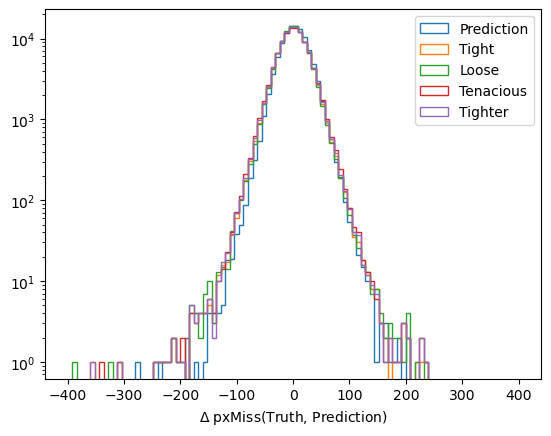

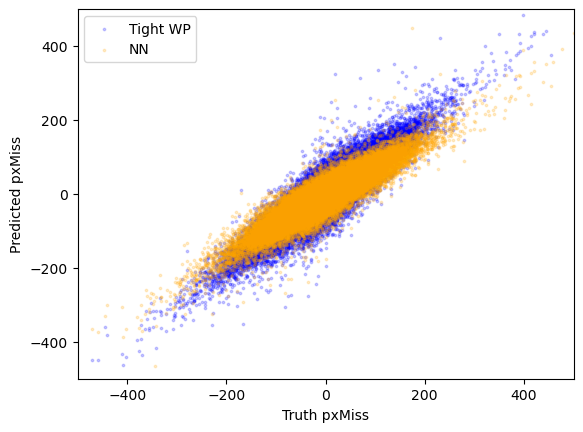

In [60]:
def plot_error(**kwargs):
    fig, ax = plt.subplots()
    ax.hist(y_test['TruthpxMiss']-pred_test[:,0], histtype='step', label='Prediction', **kwargs)
    for WP in ['Tight','Loose','Tenacious','Tighter']:
        ax.hist(y_test['TruthpxMiss'] - X_test[f'{WP}_TST_pxMiss'], histtype='step', label=WP, **kwargs)
    ax.set_yscale('log')
    ax.set_xlabel(f'$\\Delta$ pxMiss(Truth, Prediction$)$')
    ax.legend()
    plt.show()

def scatter_plot(**kwargs):
    fig, ax = plt.subplots()
    ax.scatter(y_test['TruthpxMiss'], X_test['Tight_TST_pxMiss'], alpha=0.2, c='blue', label='Tight WP', **kwargs)
    ax.scatter(y_test['TruthpxMiss'], pred_test[:,0], alpha=0.2, c='orange', label='NN',**kwargs)
    ax.set_xlabel('Truth pxMiss')
    ax.set_ylabel('Predicted pxMiss')
    ax.legend()
    ax.set_xlim(-500,500)
    ax.set_ylim(-500,500)
    plt.show()

plot_error(bins=100,range=(-400,400))
scatter_plot(s=3)

### Regression metrics

**Root Mean Squared Error & Mean Absolute Error:**

<left><img src='img/RMSE.png' width=250></left> 
<right><img src='img/MAE.png' width=240></right>
* hard to tell if a model is good (eg. RMSE = 1 is good if $\bar{y}=100$ but not if $\bar{y}=1$

**Mean Absolute Percentage Error:**

<left><img src='img/MAPE.png' width=250></left> 
* Measures relative error of the prediction
* Easy to understand quality of the model
* Sensitive to $y$ scale


**Relative Squared Error & Relative Absolute Error:**

<left><img src='img/RSE.png' width=250></left> 
<right><img src='img/RAE.png' width=240></right>
* RSE shows how the prediction errors differ from the standard deviation of the real values
* Robust to $y$ scale

**Root Mean Squared Logarithmic Error:**
<left><img src='img/RMSLE.png' width=250></left> 

* Good choice when $y_i$ varies over several orders of magnitude

In [61]:
def mean_squared_error(y_pred, y_test):
    ''' 
    Evaluate the mean squared error

    Parameters:
    y_pred: numpy array of predicted values
    y_test: numpy array of true values
    '''
    mse = np.mean( (y_pred - y_test)**2 )
    return mse

def mean_absolute_error(y_pred, y_test):
    ''' 
    Evaluate the mean squared error

    Parameters:
    y_pred: numpy array of predicted values
    y_test: numpy array of true values
    '''
    mae = np.mean( np.abs(y_pred - y_test) )
    return mae

for WP in ['Tight','Loose','Tenacious','Tighter']:
    mse = mean_squared_error(X_test[[f'{WP}_TST_pxMiss',f'{WP}_TST_pyMiss']].values, y_test)
    mae = mean_absolute_error(X_test[[f'{WP}_TST_pxMiss',f'{WP}_TST_pyMiss']].values, y_test)
    print(f'{WP} --> MSE = {mse}, MAE = {mae}')
pred_mse = mean_squared_error(pred_test, y_test)
pred_mae = mean_absolute_error(pred_test, y_test)
print(f'Prediction --> MSE = {pred_mse}, MAE = {pred_mae}')

Tight --> MSE = 721.4302368164062, MAE = 20.398406982421875
Loose --> MSE = 703.9672241210938, MAE = 20.08827781677246
Tenacious --> MSE = 773.096435546875, MAE = 21.147808074951172
Tighter --> MSE = 744.9008178710938, MAE = 20.74110984802246
Prediction --> MSE = 637.8988647460938, MAE = 19.41486930847168


#### Exercise: 
Add functions for the MAPE, RSE, RAE and RMSLE and use to evalute the trained model.

# To do:
- Relevant hyperparameters
- Dropout / regularisation
- SHAP values?